In [13]:
import os,sys
import numpy as np
import torch
import time
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
dtype = torch.float64
device = torch.device("cpu")

In [3]:
# import library for simulating Poisson point processes
cwd = os.getcwd()
dirLib = cwd + r'/library'
if dirLib not in sys.path:
    sys.path.append(dirLib)
    
import sim_deadtime_utils as sim

# Generate Simulated Data

In [188]:
# simulation resolution settings
t_sim_min = 0
t_sim_max = 40e-9
dt_sim = 1e-12

tD = 25e-9 # deadtime
Nshot = int(1e4) # number of laser shots
wrap_deadtime = True  # wrap deadtime between shots

window_bnd = [26e-9, 34e-9]

laser_pulse_width = 500e-12 # laser pulse width in seconds
target_time = 31.2e-9
target_amplitude = 1e7 # target peak count rate
background = 1e4  # background count rate

In [189]:
# generate the simulated scene time axis
t_sim = np.arange(t_sim_min,t_sim_max,dt_sim)           # simulation time
t_sim_bins = np.concatenate((t_sim,t_sim[-1:]+dt_sim))  # simulation time histogram bins

In [190]:
# generate the photon arrival rate of the profile
# Gaussian target with constant background
photon_rate_arr = target_amplitude*np.exp(-(t_sim - target_time)**2/(2*laser_pulse_width**2))+background

In [191]:
# generate photon counts

# lists of photon arrivals per laser shot
start = time.time()
t_det_lst = []  # detected photons (includes deadtime)
t_phot_lst = [] # actual photons (no dead time)

t_det_last = -100.0  # last photon detection event
for n in range(Nshot):
    # simulate a laser shot
    ptime, ctime = sim.photon_count_generator(t_sim_bins, 
                                              photon_rate_arr, 
                                              tau_d_flt=tD,
                                              last_photon_flt=t_det_last)
    if wrap_deadtime:
        if len(ctime) > 0:
            t_det_last = ctime[-1]
        t_det_last -= t_sim_bins[-1]
        
    t_det_lst += [ctime]  # detection time tags (including deadtime)
    t_phot_lst += [ptime] # photon time tags

print('time elapsed: {}'.format(time.time()-start))

time elapsed: 49.924845933914185


Text(0.5, 1.0, 'Detected Photons')

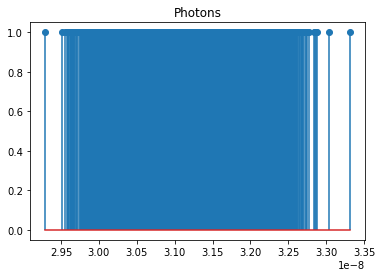

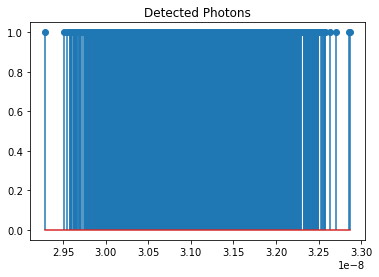

In [192]:
phot_arr = np.array(sorted(np.concatenate(t_phot_lst)))
plt.figure()
plt.stem(phot_arr,np.ones(phot_arr.size))
plt.title('Photons')

cnt_arr = np.array(sorted(np.concatenate(t_det_lst)))
plt.figure()
plt.stem(cnt_arr,np.ones(cnt_arr.size))
plt.title('Detected Photons')

In [193]:
print(len(t_det_lst))
print(np.concatenate(t_det_lst))

10000
[3.12693793e-08 3.09934253e-08 3.10637662e-08 ... 3.03044091e-08
 3.04814998e-08 3.11017061e-08]


In [194]:
flight_time = xr.DataArray(np.concatenate(t_det_lst))
flight_time = flight_time[np.where((flight_time>=window_bnd[0]) & (flight_time<window_bnd[1]))]  # Exclude specified t.o.f. bins
n_shots = Nshot
t_det_lst = t_det_lst

true_flight_time = xr.DataArray(np.concatenate(t_phot_lst))
true_flight_time = true_flight_time[np.where((true_flight_time>=window_bnd[0]) & (true_flight_time<window_bnd[1]))]


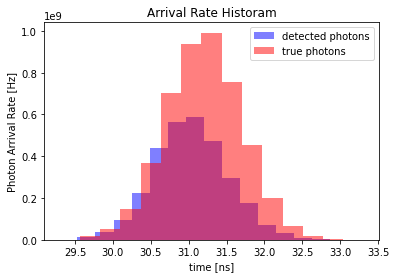

In [195]:
# Scaled time-of-flight histogram
fig = plt.figure()
ax = fig.add_subplot(111)
n, bins = np.histogram(flight_time*1e9, bins=15)
binwidth = np.diff(bins)[0]
N = n / binwidth / 1e-9 / n_shots  # [Hz] Scaling counts to arrival rate
center = 0.5 * (bins[:-1] + bins[1:])
ax.bar(center, N, align='center', width=binwidth, color='b', alpha=0.5, label='detected photons')
n, bins = np.histogram(true_flight_time*1e9, bins=15)
binwidth = np.diff(bins)[0]
N = n / binwidth / 1e-9 / n_shots  # [Hz] Scaling counts to arrival rate
center = 0.5 * (bins[:-1] + bins[1:])
ax.bar(center, N, align='center', width=binwidth, color='r', alpha=0.5, label='true photons')
ax.set_title('Arrival Rate Historam')
ax.set_xlabel('time [ns]')
ax.set_ylabel('Photon Arrival Rate [Hz]')
plt.legend()
plt.show()

Double check the integral approximation using erf()

In [31]:
t_torch = torch.tensor(t_sim)
integral_est = torch.tensor(t_sim*background) \
        + 0.5*target_amplitude*laser_pulse_width*np.sqrt(2*np.pi) \
        + 0.5*target_amplitude*laser_pulse_width*np.sqrt(2*np.pi)\
            *torch.special.erf((t_torch-target_time)/(laser_pulse_width*np.sqrt(2)))

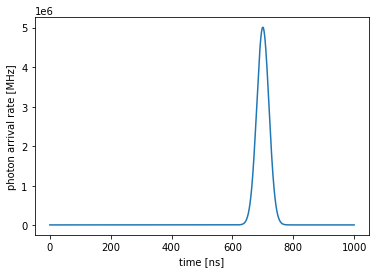

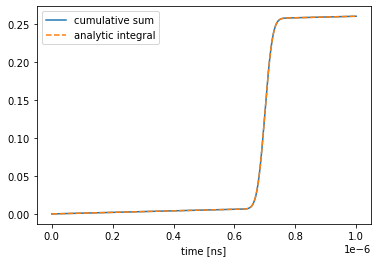

In [32]:
plt.figure()
plt.plot(t_sim*1e9,photon_rate_arr)
plt.ylabel('photon arrival rate [MHz]')
plt.xlabel('time [ns]')

plt.figure()
plt.plot(t_sim,np.cumsum(photon_rate_arr)*dt_sim, label='cumulative sum')
plt.plot(t_sim,integral_est.numpy(),'--', label='analytic integral')
plt.xlabel('time [ns]')
plt.legend()

# Fit routine from Matt for reference

# Perform Fit Using PyTorch
Assume the target is described by a Gaussian with a constant background

In [19]:
# # convert training and validation data to 
# # tensor type
# t_phot_fit_tnsr = torch.tensor(t_phot_fit)
# t_phot_val_tnsr = torch.tensor(t_phot_val)

In [20]:
# # build the fit model as a NN module
# class Fit_Pulse(torch.nn.Module):
#     def __init__(self,t_max):
#         """
#         Instantiate and initialize the fit parameters.
#         """
#         super().__init__()
#         self.log_A = torch.nn.Parameter(5*torch.ones(()))   # Gaussian amplitude
#         self.log_mu = torch.nn.Parameter(-9*torch.ones(()))  # Gaussian mean
#         self.log_sig = torch.nn.Parameter(-9*torch.ones(())) # Gaussian std
#         self.log_b = torch.nn.Parameter(3*torch.ones(()))      # background
#         self.t_max = t_max # maximum time evaluated in integral term
        
#         self.sqrt_2pi = torch.sqrt(torch.tensor(2*np.pi))
#         self.sqrt_2  = torch.sqrt(torch.tensor(2.0))
        

#     def forward(self, t):
#         """
#         Forward model the profile for input time t.
#         Also return the integral.
#         """
#         # calculate all the actual fit parameters
#         A = torch.exp(self.log_A)
#         mu = torch.exp(self.log_mu)
#         sig = torch.exp(self.log_sig)
#         b = torch.exp(self.log_b)
        
#         # calculate the forward model
#         model_out = A*torch.exp(-(t-mu)**2/(2*sig**2)) + b
        
#         # calculate the integral
#         integral_out = b*self.t_max \
#                         + 0.5*A*sig*self.sqrt_2pi \
#                         + 0.5*A*sig*self.sqrt_2pi\
#                             *torch.special.erf((self.t_max-mu)/(sig*self.sqrt_2))
        
#         return model_out, integral_out

In [21]:
# def pois_loss(prof,integral):
#     """
#     Poisson point process loss function
#     prof: estimated photon arrival rate evaluated at
#         each time tag
#     integral: integral of prof at t_max
#     """
#     return integral-torch.sum(torch.log(prof))

In [1]:
# # optimization parameters
# rel_step_lim = 1e-15  # termination criteria based on step size
# max_epochs = 5000     # maximum number of iterations/epochs
# learning_rate = 1e-1  # ADAM learning rate
# term_persist = 20     # relative step size averaging interval in iterations

In [23]:
# # initialize for fit loop
# fit_model = Fit_Pulse(t_sim[-1])
# optimizer = torch.optim.Adam(fit_model.parameters(),lr=learning_rate)
# epoch=0
# rel_step = 1e3*rel_step_lim
# train_loss_lst = []
# valid_loss_lst = []
# rel_step_lst = []

In [24]:
# # set the loss function to use a 
# # Poisson point process likelihood function
# loss_fn = pois_loss

In [25]:
# # perform fit
# while rel_step > rel_step_lim and epoch < max_epochs:
#     fit_model.train()
#     pred,integral = fit_model(t_phot_fit_tnsr)
#     loss = loss_fn(pred,integral*cnt_phot_fit)  # add regularization here
#     train_loss_lst +=[loss.item()]

#     # calculate relative step as an average over the last
#     # term_persist iterations
#     if epoch == 0:
#         rel_step_lst+=[1e3*rel_step_lim]
#         rel_step = 1e3*rel_step_lim
#     else:
#         rel_step_lst+=[(train_loss_lst[-2]-train_loss_lst[-1])/np.abs(train_loss_lst[-2])]
#         rel_step = np.abs(np.array(rel_step_lst)[-term_persist:].mean())
    
#     # calculate validation loss... for fun
#     pred_val,integral_val = fit_model(t_phot_val_tnsr)
#     loss_val = loss_fn(pred_val,integral_val*cnt_phot_val)
#     valid_loss_lst +=[loss_val.item()]

#     # update estimated parameters
#     loss.backward()
#     optimizer.step()
    
#     # zero out the gradient for the next step
#     optimizer.zero_grad()

# #     print(f"{train_loss_lst[-1]}")
    
#     epoch+=1


In [27]:
# # calculate the validation loss.
# # we would use this to determine optimimal tuning parameters
# # if we had any (e.g. more Gaussian targets)
# pred_val,integral_val = fit_model(t_phot_val_tnsr)
# loss_val = loss_fn(pred_val,integral_val*cnt_phot_val)
# print(f"Validation Loss: {loss_val}")

Validation Loss: -803.6897456506315


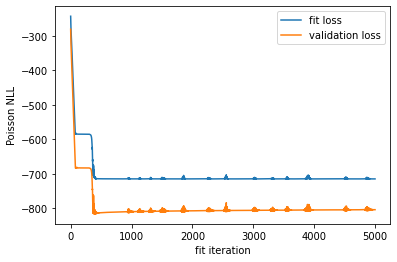

In [28]:
# # plot the loss over iterations
# plt.figure()
# plt.plot(train_loss_lst,label='fit loss')
# plt.plot(valid_loss_lst,label='validation loss')
# plt.xlabel('fit iteration')
# plt.ylabel('Poisson NLL')
# plt.legend()

Display the resulting estimate

In [29]:
# pred_mod_full,integral_full = fit_model(torch.tensor(t_sim))

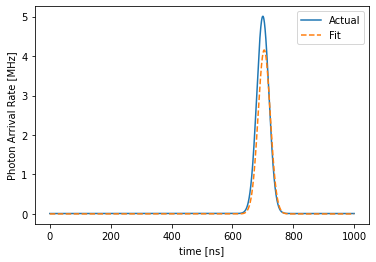

In [30]:
# plt.figure()
# plt.plot(t_sim*1e9,photon_rate_arr*1e-6,label='Actual')
# plt.plot(t_sim*1e9,pred_mod_full.detach().numpy()*1e-6,'--',label='Fit') # /cnt_phot_fit
# plt.xlabel('time [ns]')
# plt.ylabel('Photon Arrival Rate [MHz]')
# plt.legend()

In [31]:
# # calculate the modeled values at each photon arrival
# pred_mod_fit_pts,integral_fit_pts = fit_model(t_phot_fit_tnsr)
# pred_mod_val_pts,integral_val_pts = fit_model(t_phot_val_tnsr)

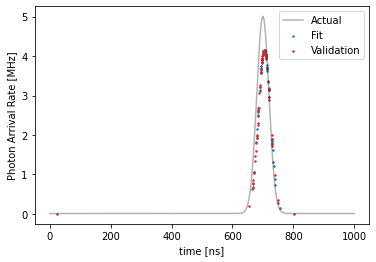

In [32]:
# plt.figure()
# plt.plot(t_sim*1e9,photon_rate_arr*1e-6,label='Actual',color='k',alpha=0.3)
# plt.scatter(t_phot_fit_tnsr.detach().numpy()*1e9,pred_mod_fit_pts.detach().numpy()*1e-6,s=2,label='Fit')
# plt.scatter(t_phot_val_tnsr.detach().numpy()*1e9,pred_mod_val_pts.detach().numpy()*1e-6,s=2,label='Validation',c='tab:red')
# plt.xlabel('time [ns]')
# plt.ylabel('Photon Arrival Rate [MHz]')
# plt.legend()